# Ensemble Learning and Random Forests
ensemble learning is very powerful provided the types of models used to create the predictions make different type of error the resulting ensemble result will be more accurate. Therefore it is very important to use very different models. 

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=10000, noise=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

log_clf = LogisticRegression()
Forest_clf = RandomForestClassifier()
svc_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('log', log_clf), ('forest', Forest_clf), ('svc', svc_clf)],
    voting='hard'
)

In [2]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('log', LogisticRegression()),
                             ('forest', RandomForestClassifier()),
                             ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, Forest_clf, svc_clf, voting_clf):
    clf.fit(X_train, y_train)
    print(clf.__class__.__name__, accuracy_score(y_test, clf.predict(X_test)))

LogisticRegression 0.8525
RandomForestClassifier 0.908
SVC 0.918
VotingClassifier 0.9155


if all of the models in the VotingClassifier contain predict_proba methods than you can change the voting to 'soft' and can access the predict_proba for the ensemble. To do this with the current code above you would need to add a hyperparameter to the SVC class as it does not offer probabilities by default.  
  
## Bagging and Pasting
one way to get a set of diverse classifiers is to use very different algorithms. Another is to use very different training algorithms, Alternatively you could train each of them on a different subset of the training data. When each of the classifiers is trained on a subset of the training data but that training data is replaced the process is known as ***bagging***. when it occurs without replacement it is called ***pasting***.
<br/>
Each individual predictor has higher bias when trained on a subset of the training set but aggregation reduces both the bias and varience. You can expect the bias of an ensemble of classifiers to be roughly the same as a single predictor but less varience. 

as each different model is trained on a different subset and use different models there is potential for parallel computation. This is why bagging and pasting are popular methods.  
  
Sklearn offers a simple API for bagging and apsting with aggingclassifier and BaggingRegression for regression. Should you watn to use pasting instead of backing you set bootstrap=False. The n_jobs parameter tells sklearn the number of CPU cores to use. -1  tells sklearn to use all available cores.

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, 
    max_samples=100, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 0])

the BaggingClassifer automatically performs soft voting instead of hard voting if the base classifier has a predict_proba() method.  
  
Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting but also varience reduced. Bagging usually produces a better model.

## Out of bag Evaluation
When using Bagging (with replacement) each individual predictor will not see all of the trainin instances. therefore to evaluate the model you can evaluate each individual predictor on the out of bag (oob) instances and average the scores of all the predictors. to do this in sklearn you can set oob_score=True.

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, 
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)

bag_clf.oob_score_ #so the bag classifier is expected to produce 89% accuracy on the test set. Lets see.

from sklearn.metrics import accuracy_score
pred = bag_clf.predict(X_test)
accuracy_score(y_test, pred) #hmmm actually better.

# Random Patches and Random Subspaces
instead of using the above bagging example for decision trees you can just use the RandomForestClassifier as follows

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

With Random Forest Classifiers the Features chosen to split the nodes will be of more importance and the surface than deeper down. It is therefore possible to get feature importance. 

from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

# Boosting
Boosting referes to a method where you train the models sequentially each one trying to reduce the error of the previous. There are many boosting metods available but AdaBoost and Gradient Boosting are the best.  
  
## AdaBoost
for the prdictor to correct the errors of its predecessor it must pay attention to the errors the predecessor made focusing more on them. after each validation the relative errors of the missclassified training instances is increased and then a second classifier is trained using the updated weights.  

To make predictions the model takes the predictions of all of the individual predictors and multiplies them by their relative weights. 

Sklearn supports and uses a multicalss version of AdaBoost called SAMME . when just using two calsses is the equivalent of Adaboost

In [5]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

# Gradient Boosting
Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. Unlike Ada however Gradient doesnt tweak the instance weights it trys to fit the new predictor to the residual errors made by the previous predictor.

In [6]:
X_train.shape, y_train.shape

((8000, 2), (8000,))

In [7]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X_train, y_train)

y2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X_train, y2)

y3 = y2 - tree_reg2.predict(X_train)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X_train, y3)

DecisionTreeRegressor(max_depth=2)

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

***To find the perfect number of trees it is optimal to use early stopping. A simple simple way to implement is with the staged_predict() metod:***

In [9]:
import numpy as np 
from sklearn.metrics import mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt= GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=119)

the above code trains the whole model and then picks the most accurate stage you can train the model in stages and stop training when it starts to overfit. 

In [10]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 500):
    gbrt.n_estimators = n_estimators 
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else: 
        error_going_up += 1 
        if error_going_up == 5:
            break

In [11]:
n_estimators

173

# Stacking
short from stacked generalization. all of the models in the ensembles makes tpredictions and then a final predictor called a blender takes these predictions and makes the final prediction. 
if you are just using one layer of stacking you split your training data in two. 
you train your first layer of predictors with one set. then use the predictors to make predictions of the other set. these predictions act as inputs to your blender model. 

Sci-kit learn does not support stacking but it would be simple enough to implement your own version.  
    
# Question Answers

In [12]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

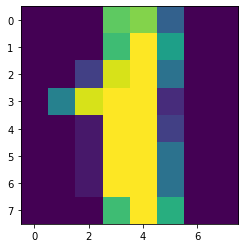

In [13]:
plt.imshow(digits['images'][1])

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(digits['data'], digits['target'], test_size=0.2)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier


In [42]:
class blender():
    def __init__(self): 
        print('initialised')
        return None 
    def fit(self, X_data, y_data):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

        tree_clf = RandomForestClassifier()
        SVC_clf = SVC(probability=True)
        extra_tree_clf = ExtraTreesClassifier()
        KNN = KNeighborsClassifier()

        pred_arrays = []
        for model in (tree_clf , SVC_clf, extra_tree_clf):
            model.fit(X_train, y_train)
            pred_arrays.append(np.array(model.predict(X_test)))
        

        L2_train = (np.asmatrix(pred_arrays)).T
        KNN.fit(L2_train, y_test)
        
        self.KNN = KNN
        self.tree_clf = tree_clf
        self.extra_tree_clf = extra_tree_clf
        self.SVC_clf = SVC_clf
        print('models trained')
        return self
    def predict(self, data):
        L2_data = (np.asmatrix([self.tree_clf.predict(data),
                                self.SVC_clf.predict(data),
                                self.extra_tree_clf.predict(data)]).T)
        final_preds = self.KNN.predict(L2_data)
        return final_preds

In [43]:
X_train, X_test, y_train, y_test = train_test_split(digits['data'], digits['target'], test_size=0.3)


In [44]:

blender = blender()

initialised


In [45]:
blender.fit(digits['data'], digits['target'])

models trained


In [57]:
pred = blender.predict(X_test)
blender_prec = precision_score(y_test, pred, average='macro') 

SVC_clf = SVC(probability=True)
tree = RandomForestClassifier()
extra_trees = ExtraTreesClassifier()

voting_ens = VotingClassifier(
    estimators=[('tree', tree), ('SVC', SVC_clf), ('extra_trees', extra_trees)],
    voting='hard')

***Lets see which scores best***

In [61]:
for model in (SVC_clf, tree, extra_trees, voting_ens):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = precision_score(y_test, preds, average='macro')
    print(model.__class__.__name__, score)
print('blender ', blender_prec)

SVC 0.9945043552938291
RandomForestClassifier 0.9682576226572387
ExtraTreesClassifier 0.9926538473112455
VotingClassifier 0.9846195620304021
blender  0.9961538461538462
